# Практическая работа: Анализ временных рядов и прогнозирование

## Цель работы
Освоить практические навыки анализа и прогнозирования временных рядов, включая декомпозицию, тестирование стационарности, построение ARIMA моделей и применение машинного обучения.

## Задания для выполнения
В этой практической работе вы выполните 8 заданий, каждое из которых направлено на освоение определенного аспекта анализа временных рядов.

**Важно:** Используйте TimeSeriesSplit для валидации моделей машинного обучения!

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Библиотеки для временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Машинное обучение
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Настройка графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# Для воспроизводимости результатов
np.random.seed(42)

print("✅ Библиотеки успешно импортированы")

✅ Библиотеки успешно импортированы


## Создание датасета

Создадим синтетический временной ряд с известными компонентами для практики.

In [2]:
# Создание синтетического временного ряда
n = 730  # 2 года дневных данных
dates = pd.date_range(start='2022-01-01', periods=n, freq='D')

# Компоненты временного ряда
time = np.arange(n)
trend = 0.03 * time + 100  # Линейный тренд
seasonal_yearly = 15 * np.sin(2 * np.pi * time / 365)  # Годовая сезонность
seasonal_weekly = 5 * np.sin(2 * np.pi * time / 7)  # Недельная сезонность
noise = np.random.normal(0, 3, n)  # Случайный шум

# Аддитивная модель
ts_values = trend + seasonal_yearly + seasonal_weekly + noise

# Создание DataFrame
df = pd.DataFrame({
    'date': dates,
    'value': ts_values
})
df.set_index('date', inplace=True)

print(f"Создан временной ряд:")
print(f"  Период: {df.index[0].date()} - {df.index[-1].date()}")
print(f"  Количество наблюдений: {len(df)}")
print(f"\nПервые 5 значений:")
print(df.head())
print(f"\nОписательная статистика:")
print(df.describe())

Создан временной ряд:
  Период: 2022-01-01 - 2023-12-31
  Количество наблюдений: 730

Первые 5 значений:
                 value
date                  
2022-01-01  101.490142
2022-01-02  103.782565
2022-01-03  107.394029
2022-01-04  107.602803
2022-01-05   98.280158

Описательная статистика:
            value
count  730.000000
mean   110.898253
std     10.862901
min     83.099500
25%    103.089821
50%    110.598493
75%    118.950372
max    142.412141


## TODO 1: Визуализация и первичный анализ временного ряда

**Задание:**
1. Постройте график временного ряда
2. Добавьте скользящее среднее (rolling mean) с окном 30 дней
3. Добавьте доверительный интервал (rolling mean ± 2*rolling std)
4. Проанализируйте визуально: есть ли тренд? сезонность? выбросы?
5. Постройте гистограмму распределения значений
6. Постройте boxplot по месяцам для выявления сезонности

**Подсказка:** Используйте `df.rolling(window=30)` для скользящих статистик

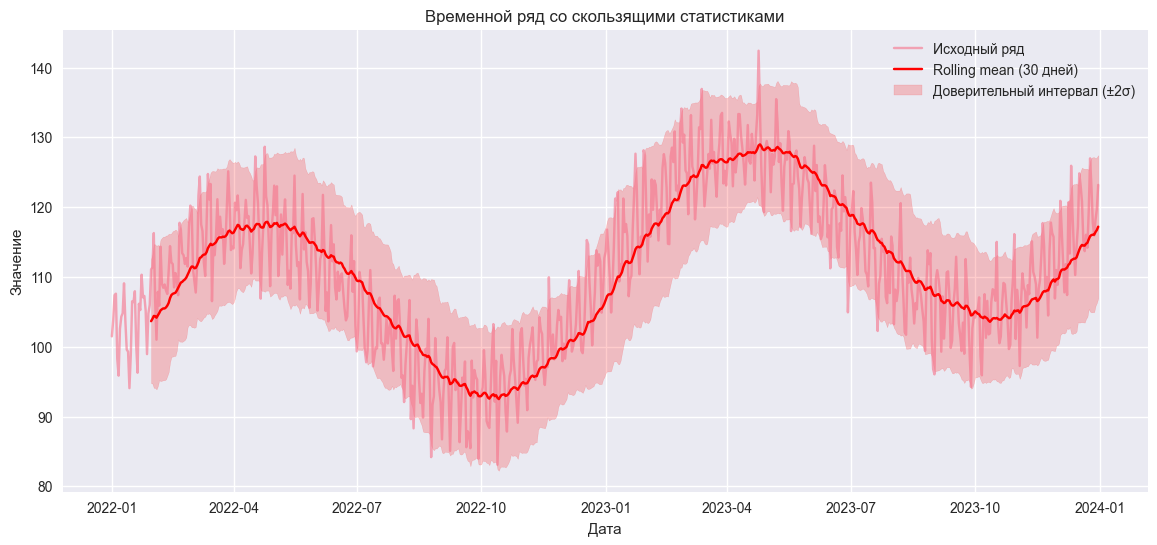

In [3]:
# TODO: Ваш код здесь
# Визуализация временного ряда со скользящим средним
df.index = pd.to_datetime(df.index)

# rolling статистики
rolling_mean = df['value'].rolling(window=30).mean()
rolling_std = df['value'].rolling(window=30).std()

upper_bound = rolling_mean + 2 * rolling_std
lower_bound = rolling_mean - 2 * rolling_std

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], label='Исходный ряд', alpha=0.6)
plt.plot(df.index, rolling_mean, label='Rolling mean (30 дней)', color='red')
plt.fill_between(df.index, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label='Доверительный интервал (±2σ)')

plt.title('Временной ряд со скользящими статистиками')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

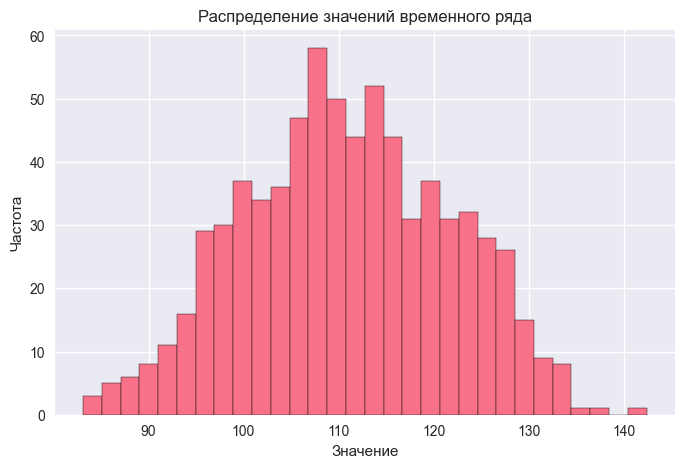

In [4]:
# TODO: Ваш код здесь
# Гистограмма распределения
plt.figure(figsize=(8, 5))
plt.hist(df['value'], bins=30, edgecolor='black')
plt.title('Распределение значений временного ряда')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()


<Figure size 1200x600 with 0 Axes>

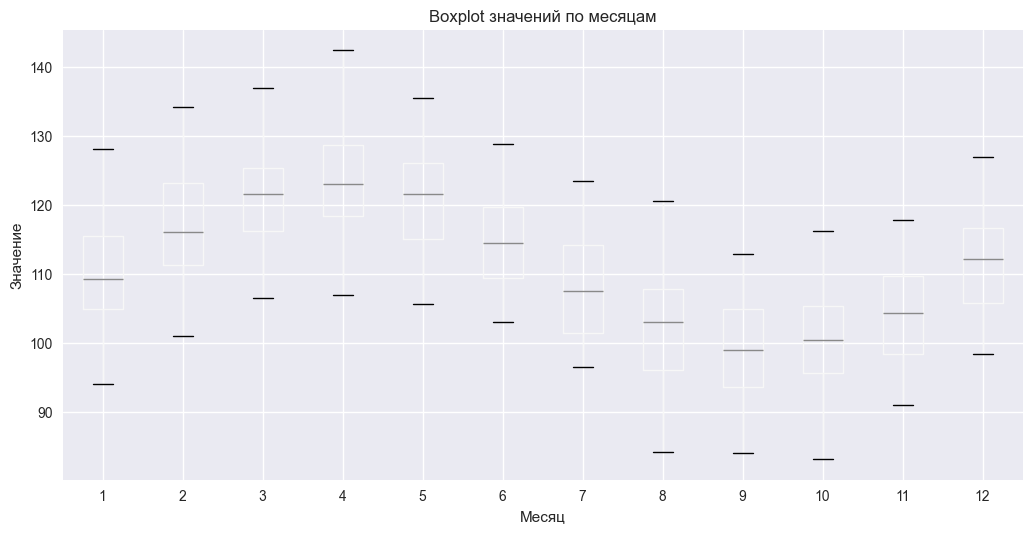

In [5]:
# TODO: Ваш код здесь
# Boxplot по месяцам
df['month'] = df.index.month

plt.figure(figsize=(12, 6))
df.boxplot(column='value', by='month')
plt.title('Boxplot значений по месяцам')
plt.suptitle('')
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.show()


## TODO 2: Декомпозиция временного ряда

**Задание:**
1. Выполните декомпозицию временного ряда (используйте `seasonal_decompose`)
2. Попробуйте аддитивную модель с периодом 365
3. Попробуйте мультипликативную модель с периодом 365
4. Визуализируйте компоненты обеих декомпозиций
5. Сравните остатки (residuals) аддитивной и мультипликативной моделей
6. Определите, какая модель лучше подходит для данных и почему
7. Проанализируйте сезонную компоненту: какой паттерн повторяется?

**Требования:**
- Создайте функцию для анализа остатков (среднее, std, тест на нормальность)
- Постройте гистограмму остатков
- Сделайте выводы в текстовой ячейке

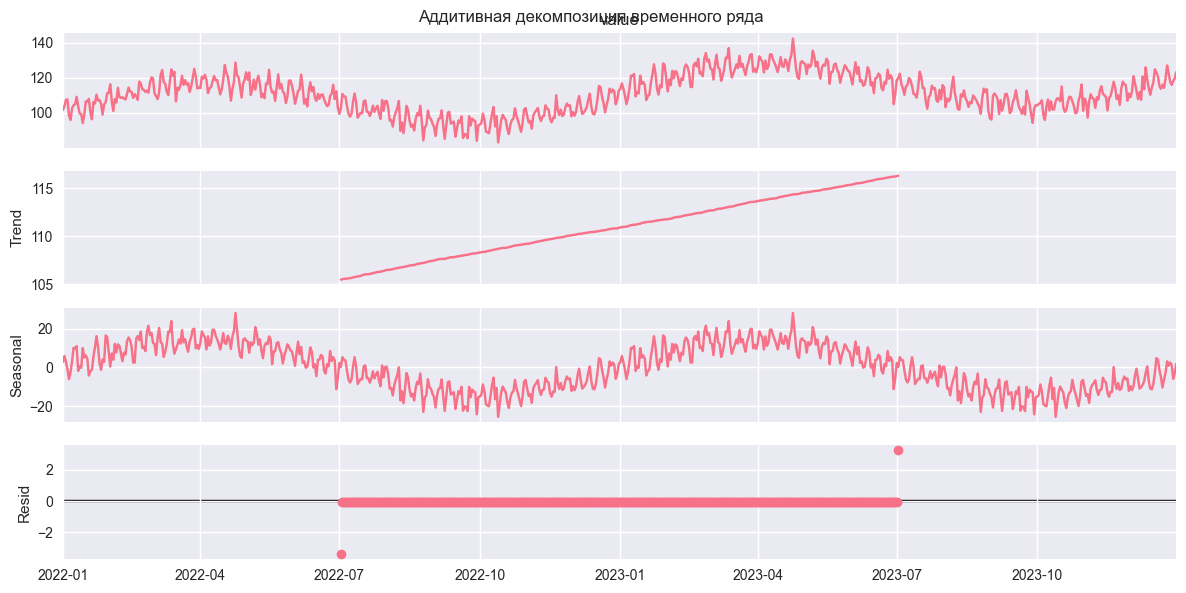

In [10]:
# TODO: Ваш код здесь
# Аддитивная декомпозиция
# аддитивная модель
decomp_add = seasonal_decompose(
    df['value'],
    model='additive',
    period=365
)
decomp_add.plot()
plt.suptitle('Аддитивная декомпозиция временного ряда', fontsize=12)
plt.show()



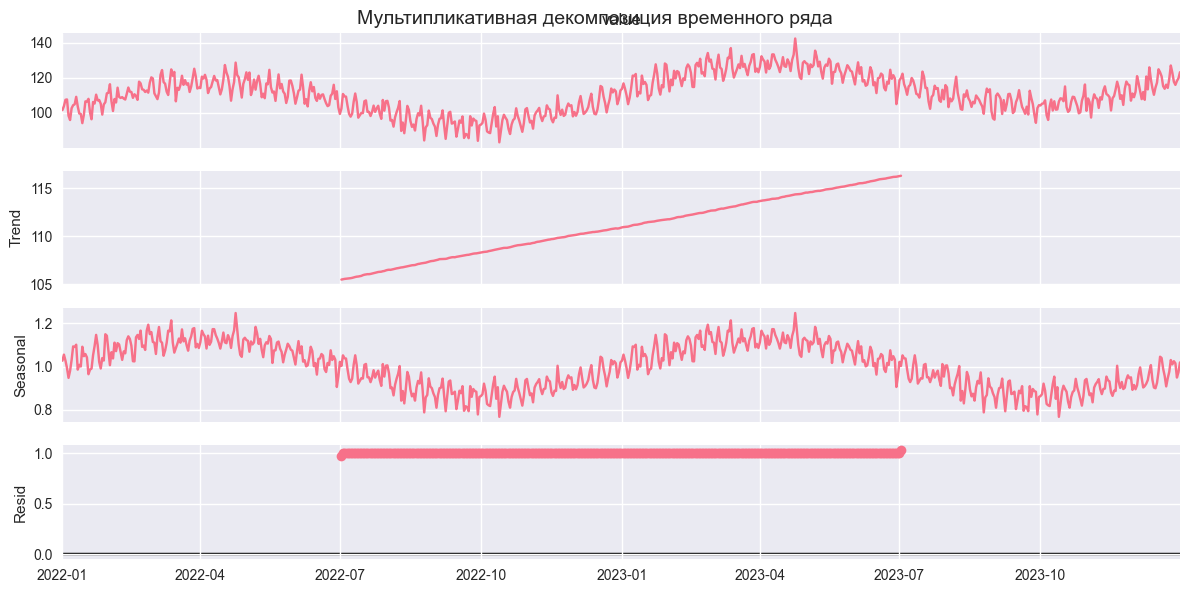

In [11]:
# TODO: Ваш код здесь
# Мультипликативная декомпозиция

# мультипликативная модель
decomp_mul = seasonal_decompose(
    df['value'],
    model='multiplicative',
    period=365
)
decomp_mul.plot()
plt.suptitle('Мультипликативная декомпозиция временного ряда', fontsize=14)
plt.show()


Анализ остатков (Аддитивная модель)
Среднее: -0.0621
Стандартное отклонение: 0.2460
Shapiro-Wilk p-value: 0.0000
→ Остатки НЕ являются нормальными

Анализ остатков (Мультипликативная модель)
Среднее: 0.9974
Стандартное отклонение: 0.0022
Shapiro-Wilk p-value: 0.0000
→ Остатки НЕ являются нормальными


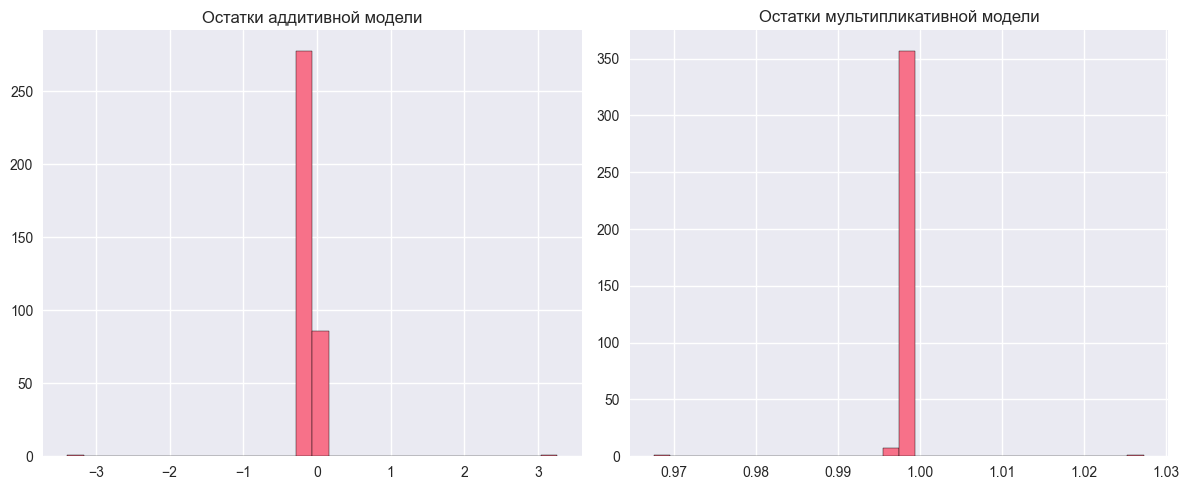

In [ ]:
# TODO: Ваш код здесь
# Функция для анализа остатков
from scipy.stats import shapiro
def analyze_residuals(residuals, model_name):
    residuals = residuals.dropna()
    
    mean = residuals.mean()
    std = residuals.std()
    
    stat, p_value = shapiro(residuals.sample(
        min(len(residuals), 5000), random_state=42
    ))
    
    print(f'Анализ остатков ({model_name} модель)')
    print(f'Среднее: {mean:.4f}')
    print(f'Стандартное отклонение: {std:.4f}')
    print(f'Shapiro-Wilk p-value: {p_value:.4f}')
    
    if p_value > 0.05:
        print('→ Остатки близки к нормальному распределению')
    else:
        print('→ Остатки НЕ являются нормальными')

# Применение функции к остаткам
analyze_residuals(decomp_add.resid, 'Аддитивная')
print()
analyze_residuals(decomp_mul.resid, 'Мультипликативная')
#Гистограммы остатков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(decomp_add.resid.dropna(), bins=30, edgecolor='black')
plt.title('Остатки аддитивной модели')

plt.subplot(1, 2, 2)
plt.hist(decomp_mul.resid.dropna(), bins=30, edgecolor='black')
plt.title('Остатки мультипликативной модели')

plt.tight_layout()
plt.show()


**TODO: Ваши выводы здесь**

Анализ декомпозиции:
- Какая модель лучше (аддитивная или мультипликативная) и почему?
- Что показывает тренд?
- Какой период сезонности наблюдается?
- Являются ли остатки белым шумом?

## TODO 3: Тестирование стационарности

**Задание:**
1. Реализуйте функцию `test_stationarity()` которая:
   - Выполняет ADF тест
   - Выполняет KPSS тест
   - Выводит результаты обоих тестов
   - Делает вывод о стационарности
   - Визуализирует ряд с rolling mean и rolling std

2. Примените функцию к исходному ряду

3. Если ряд нестационарен, примените преобразования:
   - Первое дифференцирование
   - Логарифмирование (если значения положительные)
   - Логарифмирование + дифференцирование

4. Протестируйте каждое преобразование

5. Выберите оптимальное преобразование для достижения стационарности

**Важно:** 
- ADF: H₀ = ряд нестационарен, p < 0.05 → стационарен
- KPSS: H₀ = ряд стационарен, p >= 0.05 → стационарен

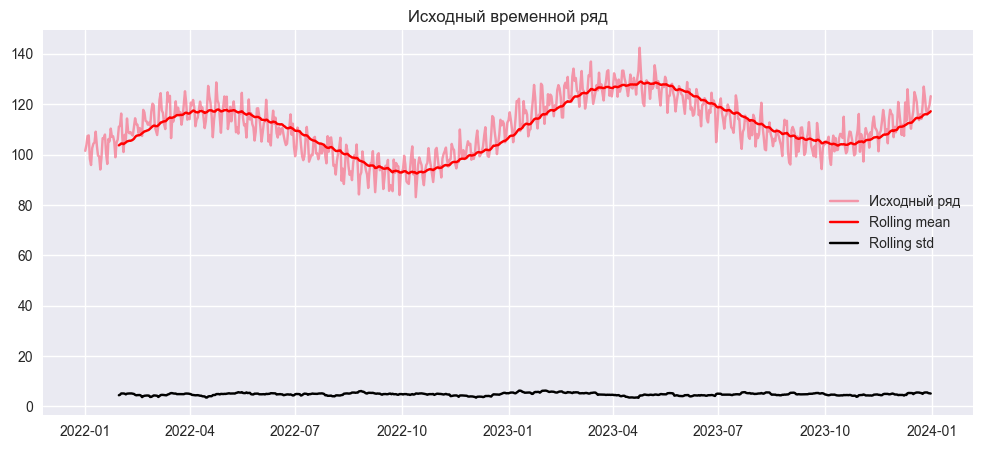

ADF тест:
  Статистика = -1.4700
  p-value    = 0.5483

KPSS тест:
  Статистика = 0.6173
  p-value    = 0.0211

Вывод:
→ Ряд нестационарен


In [17]:
# TODO: Ваш код здесь
def test_stationarity(series, window=30, title='Временной ряд'):
    series = series.dropna()
    
    # --- Rolling statistics ---
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    plt.figure(figsize=(12, 5))
    plt.plot(series, label='Исходный ряд', alpha=0.7)
    plt.plot(rolling_mean, label='Rolling mean', color='red')
    plt.plot(rolling_std, label='Rolling std', color='black')
    plt.title(title)
    plt.legend()
    plt.show()
    
    # --- ADF тест ---
    adf_result = adfuller(series)
    adf_stat, adf_p = adf_result[0], adf_result[1]
    
    # --- KPSS тест ---
    kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags='auto')
    
    print('ADF тест:')
    print(f'  Статистика = {adf_stat:.4f}')
    print(f'  p-value    = {adf_p:.4f}')
    
    print('\nKPSS тест:')
    print(f'  Статистика = {kpss_stat:.4f}')
    print(f'  p-value    = {kpss_p:.4f}')
    
    # --- Интерпретация ---
    adf_stationary = adf_p < 0.05
    kpss_stationary = kpss_p >= 0.05
    
    print('\nВывод:')
    if adf_stationary and kpss_stationary:
        print('→ Ряд стационарен')
    elif not adf_stationary and not kpss_stationary:
        print('→ Ряд нестационарен')
    else:
        print('→ Противоречивые результаты (частично стационарен)')


# Тестирование исходного ряда
test_stationarity(df['value'], title='Исходный временной ряд')


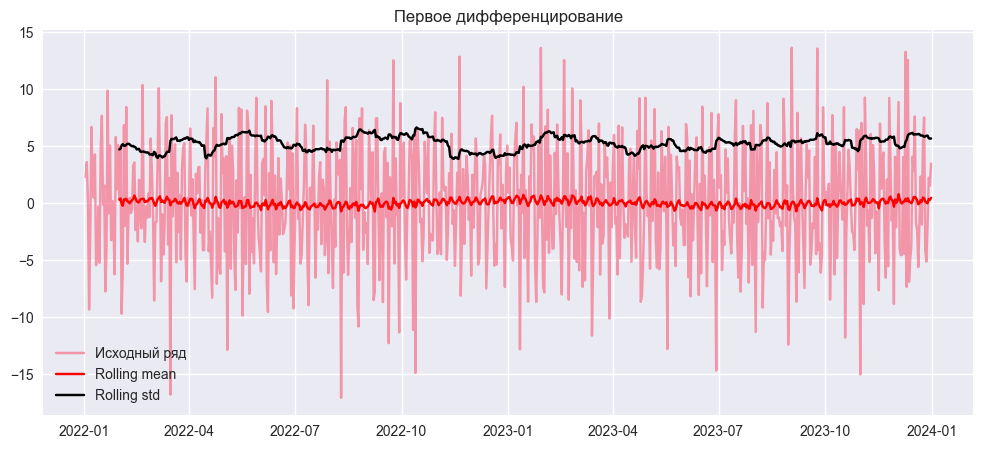

ADF тест:
  Статистика = -4.9859
  p-value    = 0.0000

KPSS тест:
  Статистика = 0.0959
  p-value    = 0.1000

Вывод:
→ Ряд стационарен


C:\Users\Расул\AppData\Local\Temp\ipykernel_27148\826096347.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags='auto')


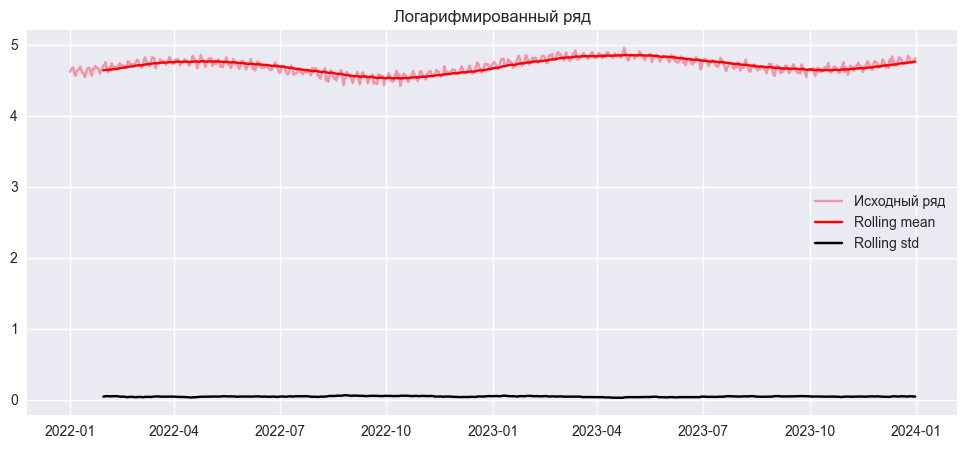

ADF тест:
  Статистика = -1.4802
  p-value    = 0.5433

KPSS тест:
  Статистика = 0.6181
  p-value    = 0.0210

Вывод:
→ Ряд нестационарен


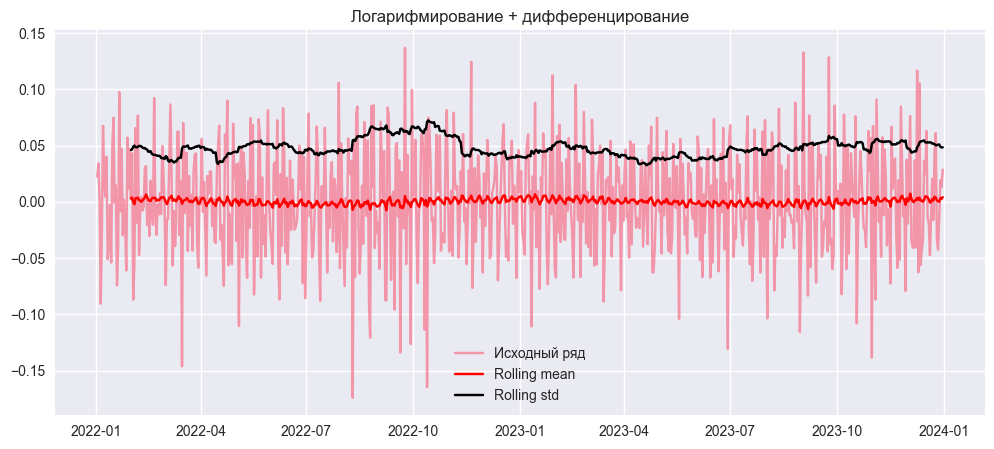

ADF тест:
  Статистика = -4.9622
  p-value    = 0.0000

KPSS тест:
  Статистика = 0.0766
  p-value    = 0.1000

Вывод:
→ Ряд стационарен


C:\Users\Расул\AppData\Local\Temp\ipykernel_27148\826096347.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(series, regression='c', nlags='auto')


In [18]:
# TODO: Ваш код здесь
# Преобразования временного ряда

# 1. Первое дифференцирование
df['diff_1'] = None  # TODO
diff_1 = df['value'].diff()

test_stationarity(diff_1, title='Первое дифференцирование')

# 2. Логарифмирование (если значения положительные)
df['log'] = None  # TODO
log_series = np.log(df['value'])

test_stationarity(log_series, title='Логарифмированный ряд')

# 3. Логарифмирование + дифференцирование
df['log_diff'] = None  # TODO
log_diff = np.log(df['value']).diff()

test_stationarity(log_diff, title='Логарифмирование + дифференцирование')

# Тестирование каждого преобразования

**TODO: Ваши выводы здесь**

Результаты тестирования стационарности:
- Является ли исходный ряд стационарным?
- Какое преобразование делает ряд стационарным?
- Какое значение параметра d использовать в ARIMA?

## TODO 4: Анализ ACF и PACF, определение параметров ARIMA

**Задание:**
1. Постройте ACF и PACF графики для стационарного ряда
2. Проанализируйте графики:
   - Определите порядок AR (p) по PACF
   - Определите порядок MA (q) по ACF
   - Учтите параметр d из предыдущего задания
3. Создайте таблицу с несколькими вариантами параметров (p, d, q)
4. Для каждого варианта обучите ARIMA модель
5. Сравните модели по AIC и BIC
6. Выберите лучшую модель

**Подсказка:** 
- PACF обрывается после лага p → AR(p)
- ACF обрывается после лага q → MA(q)
- Обычно p, q ∈ {0, 1, 2, 3}

<Figure size 1200x400 with 0 Axes>

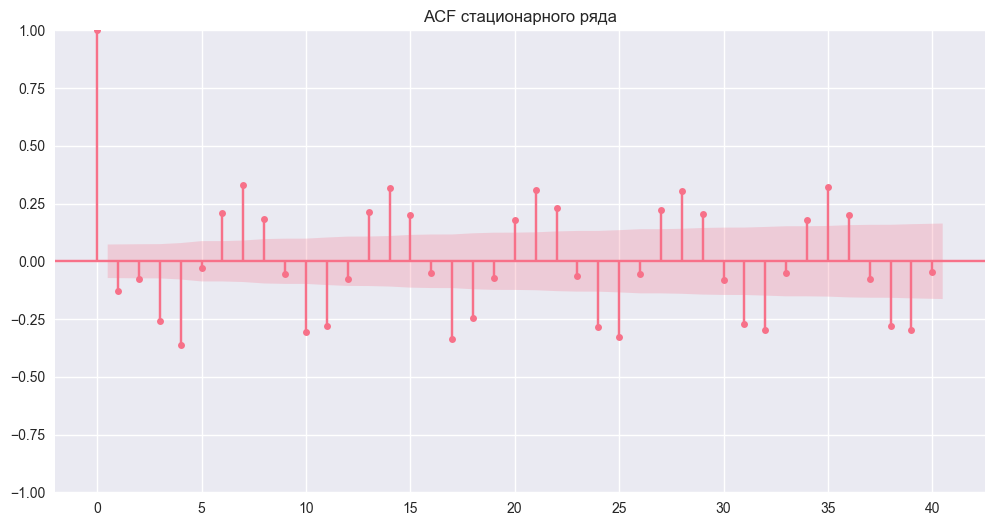

<Figure size 1200x400 with 0 Axes>

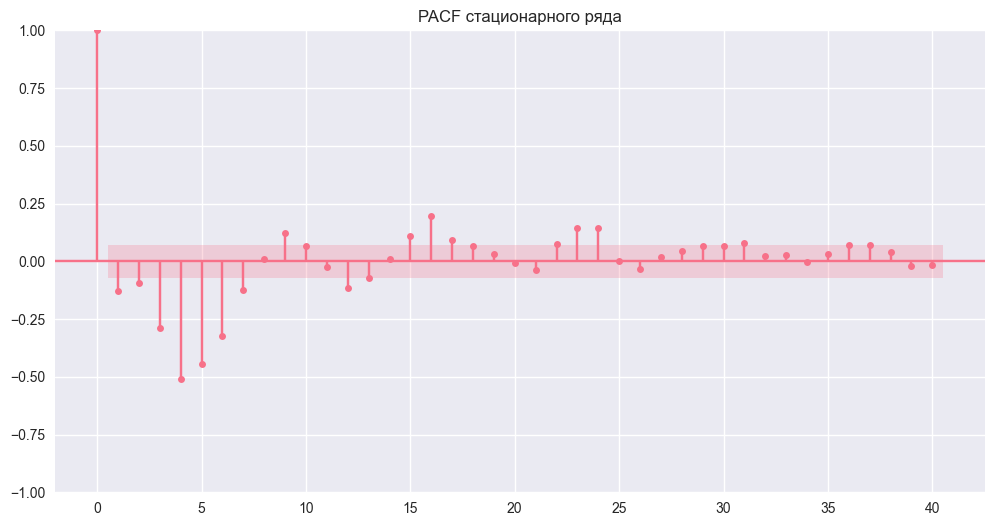

In [20]:
# TODO: Ваш код здесь
# Построение ACF и PACF для стационарного ряда
lags = 40  
y_stat = df['value'].diff().dropna()

plt.figure(figsize=(12,4))
plot_acf(y_stat.dropna(), lags=lags)
plt.title("ACF стационарного ряда")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(y_stat.dropna(), lags=lags, method="ywm")
plt.title("PACF стационарного ряда")
plt.show()

In [21]:
# TODO: Ваш код здесь
# Сравнение различных моделей ARIMA

# Разделение на train/test (80/20)
train_size = int(len(df) * 0.8)
train = df['value'][:train_size]
test = df['value'][train_size:]

print(f"Train: {len(train)}, Test: {len(test)}")

# Варианты параметров для тестирования
param_combinations = [
    (0, 1, 0),
    (1, 1, 0),
    (0, 1, 1),
    (1, 1, 1),
    (2, 1, 1),
    (1, 1, 2),
    (2, 1, 2),
]


results = []

# TODO: Для каждой комбинации параметров:
for order in param_combinations:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        
        results.append({
            "p": order[0],
            "d": order[1],
            "q": order[2],
            "AIC": model_fit.aic,
            "BIC": model_fit.bic
        })
        
    except Exception as e:
        print(f"Ошибка для ARIMA{order}: {e}")
results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by="AIC").reset_index(drop=True)

results_df
# 3. Сохраните результаты

# TODO: Создайте DataFrame с результатами и отсортируйте по AIC
best_model = results_df.iloc[0]

print("Лучшая модель:")
print(f"ARIMA({int(best_model.p)}, {int(best_model.d)}, {int(best_model.q)})")
print(f"AIC: {best_model.AIC:.2f}")
print(f"BIC: {best_model.BIC:.2f}")


Train: 584, Test: 146


d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\stat

Лучшая модель:
ARIMA(2, 1, 2)
AIC: 3259.84
BIC: 3281.68


**TODO: Ваши выводы здесь**

Выбор параметров ARIMA:
- Какие значения p и q вы определили по графикам?
- Какая модель имеет наименьший AIC?
- Какая модель выбрана как финальная и почему?

## TODO 5: Обучение и диагностика ARIMA модели

**Задание:**
1. Обучите выбранную ARIMA модель на обучающих данных
2. Выведите summary модели и проанализируйте:
   - Коэффициенты и их значимость (p-values)
   - AIC, BIC
3. Проведите диагностику остатков:
   - Постройте график остатков
   - Гистограмму остатков
   - Q-Q plot для проверки нормальности
   - ACF остатков (должна быть близка к нулю)
   - Тест Ljung-Box для автокорреляции остатков
4. Сделайте прогноз на тестовый период
5. Визуализируйте прогноз с доверительным интервалом
6. Вычислите метрики: MAE, RMSE, MAPE

**Важно:** Хорошая модель → остатки = белый шум (нет автокорреляции)

In [22]:
# TODO: Ваш код здесь

best_order = (int(best_model.p), int(best_model.d), int(best_model.q))  # если best_model уже есть
# либо вручную: best_order = (1, 1, 1)

model = ARIMA(train, order=best_order)
model_fit = model.fit()

print("ARIMA order:", best_order)
print(model_fit.summary())



d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA order: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  584
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1624.918
Date:                Sat, 13 Dec 2025   AIC                           3259.836
Time:                        13:59:26   BIC                           3281.677
Sample:                    01-01-2022   HQIC                          3268.350
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0898      0.041     26.464      0.000       1.009       1.171
ar.L2         -0.6760      0.036    -19.005      0.000      -0.746      -0.606
ma.L1         -1.5947      0.

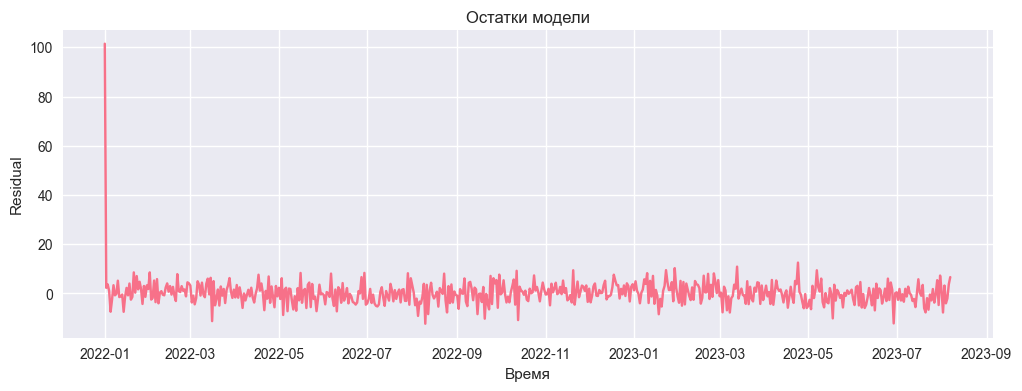

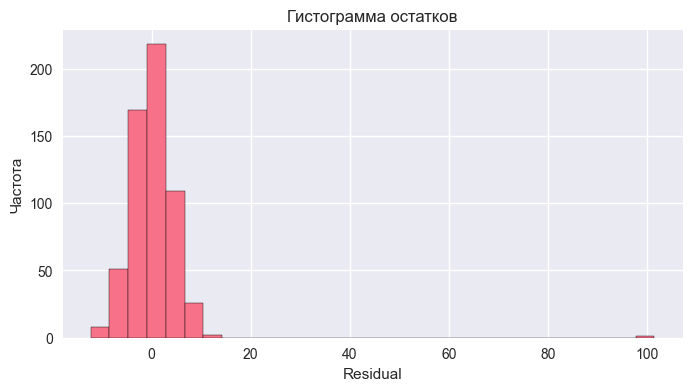

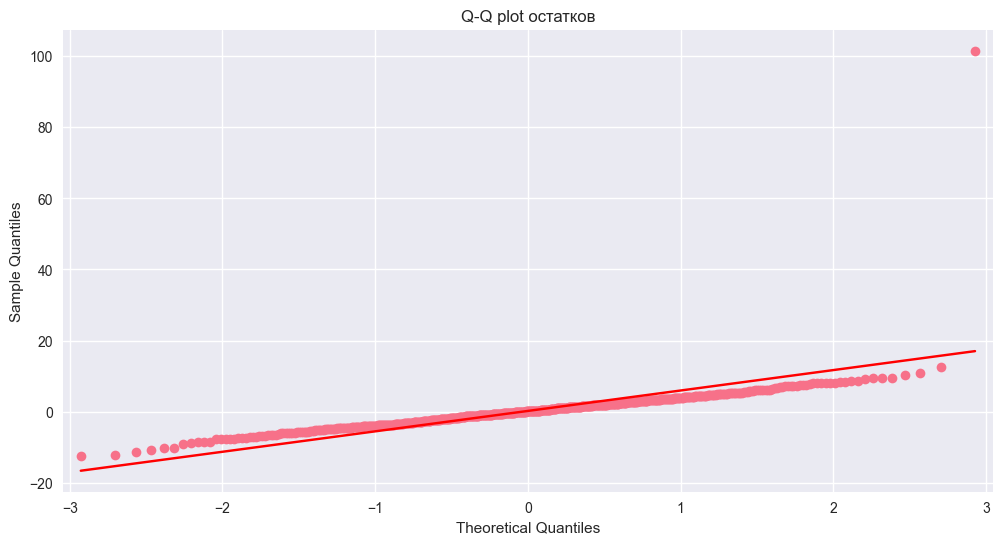

,lb_stat,lb_pvalue
10,18.814255,0.042686
20,33.480289,0.029863
30,51.708872,0.008186


In [34]:
# TODO: Ваш код здесь
# Диагностика остатков
resid = model_fit.resid.dropna()
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title("Остатки модели")
plt.xlabel("Время")
plt.ylabel("Residual")
plt.show()
plt.figure(figsize=(8,4))
plt.hist(resid, bins=30, edgecolor="black")
plt.title("Гистограмма остатков")
plt.xlabel("Residual")
plt.ylabel("Частота")
plt.show()
import statsmodels.api as sm

sm.qqplot(resid, line="s")
plt.title("Q-Q plot остатков")
plt.show()
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
lb


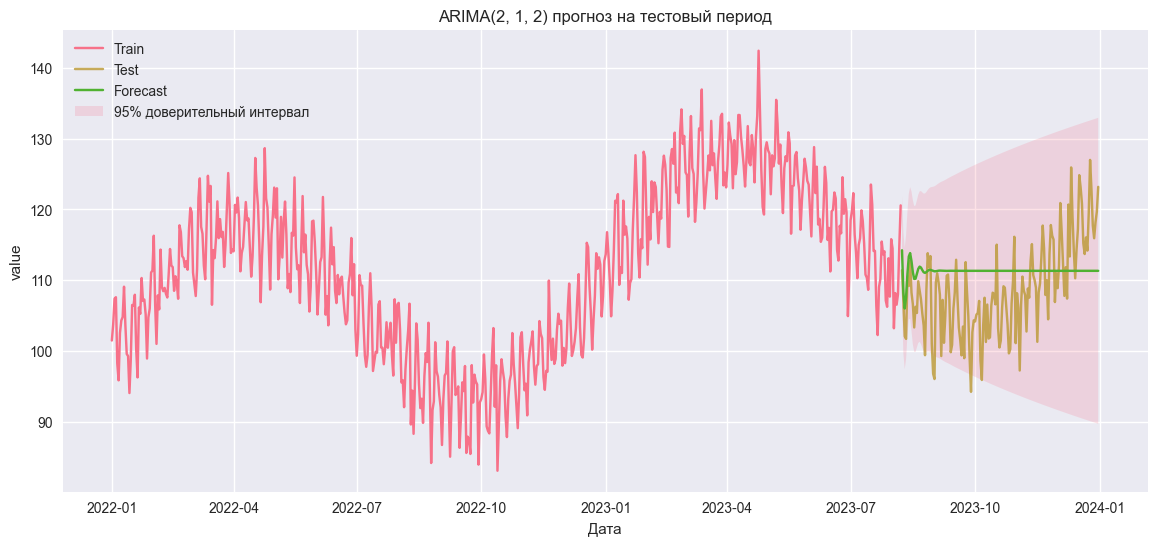

In [35]:
# TODO: Ваш код здесь
# Прогнозирование и визуализация
forecast_res = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.05)  # 95% CI

# подгоним индексы, чтобы совпадали с test
forecast_mean.index = test.index
forecast_ci.index = test.index
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", alpha=0.8)
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% доверительный интервал"
)

plt.title(f"ARIMA{best_order} прогноз на тестовый период")
plt.xlabel("Дата")
plt.ylabel("value")
plt.legend()
plt.show()


In [39]:
# TODO: Ваш код здесь
# Вычисление метрик качества
def calculate_metrics(y_true, y_pred):
    
    # приводим к numpy и выравниваем индексы
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE (защита от деления на ноль)
    eps = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100
    
    r2 = r2_score(y_true, y_pred)
    
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R²": r2
    }
metrics = calculate_metrics(test, forecast_mean)

print(f"MAE:  {metrics['MAE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAPE: {metrics['MAPE (%)']:.2f}%")
print(f"R²:   {metrics['R²']:.4f}")


MAE:  5.7521
RMSE: 7.0025
MAPE: 5.39%
R²:   -0.1275


**TODO: Ваши выводы здесь**

Анализ ARIMA модели:
- Являются ли остатки белым шумом?
- Какое качество прогноза по метрикам?
- Есть ли систематические ошибки в прогнозах?

## TODO 6: Feature Engineering для машинного обучения

**Задание:**
1. Создайте функцию `create_features()` которая генерирует:
   - **Лаговые признаки**: lag_1, lag_2, lag_7, lag_14, lag_30
   - **Скользящие статистики**: rolling_mean, rolling_std, rolling_min, rolling_max (окна: 7, 14, 30)
   - **Временные признаки**: день недели, день месяца, месяц, квартал, is_weekend
   - **Разностные признаки**: diff_1, diff_7, pct_change
   - **EMA**: exponential moving average (7, 30)

2. Примените функцию к данным

3. Обработайте пропущенные значения

4. Разделите на X (признаки) и y (целевая переменная)

5. Разделите на train/test с сохранением временного порядка (80/20)

6. Масштабируйте признаки (StandardScaler)

**Важно:** 
- НЕ перемешивайте данные!
- Используйте только .shift() для лагов (не заглядываем в будущее)
- Fit scaler только на train данных

In [76]:
# TODO: Ваш код здесь
import numpy as np
import pandas as pd

def create_features(df, target_col='value', date_col=None):
    data = df.copy()

    # --- дата/индекс ---
    if date_col is not None:
        data[date_col] = pd.to_datetime(data[date_col])
        data = data.sort_values(date_col).set_index(date_col)
    else:
        if not isinstance(data.index, pd.DatetimeIndex):
            data.index = pd.to_datetime(data.index)
        data = data.sort_index()

    # --- target как число ---
    data[target_col] = pd.to_numeric(data[target_col], errors='coerce')

    # --- обработка пропусков ТОЛЬКО в target (чтобы rolling/lag не убил всё) ---
    # интерполяция по времени + добивка краёв
    data[target_col] = data[target_col].interpolate(method='time')
    data[target_col] = data[target_col].ffill().bfill()

    y = data[target_col]

    # --- Лаги ---
    for lag in [1, 2, 7, 14, 30]:
        data[f'lag_{lag}'] = y.shift(lag)

    # --- Rolling статистики (без утечки в будущее: rolling смотрит назад) ---
    for w in [7, 14, 30]:
        roll = y.rolling(window=w, min_periods=w)   # строго: считаем только когда есть полное окно
        data[f'rolling_mean_{w}'] = roll.mean()
        data[f'rolling_std_{w}']  = roll.std()
        data[f'rolling_min_{w}']  = roll.min()
        data[f'rolling_max_{w}']  = roll.max()

    # --- Временные признаки ---
    idx = data.index
    data['dayofweek'] = idx.dayofweek
    data['day'] = idx.day
    data['month'] = idx.month
    data['quarter'] = idx.quarter
    data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

    # --- Разностные признаки ---
    data['diff_1'] = y.diff(1)
    data['diff_7'] = y.diff(7)
    data['pct_change'] = y.pct_change()

    # --- EMA ---
    data['ema_7'] = y.ewm(span=7, adjust=False).mean()
    data['ema_30'] = y.ewm(span=30, adjust=False).mean()

    return data


    # --- Разностные признаки ---
    data['diff_1'] = y.diff(1)
    data['diff_7'] = y.diff(7)
    data['pct_change'] = y.pct_change()

    # --- EMA ---
    data['ema_7'] = y.ewm(span=7, adjust=False).mean()
    data['ema_30'] = y.ewm(span=30, adjust=False).mean()

    # --- Очистка ---
    if dropna:
        data = data.dropna()

    return data


    


# Применение функции
# Генерация признаков
features_df = create_features(df, target_col='value')
features_df = features_df.replace([np.inf, -np.inf], np.nan)
# Проверим результат
features_df.head()



,value,month,diff_1,log,log_diff,lag_1,lag_2,lag_7,lag_14,lag_30,...,rolling_min_30,rolling_max_30,dayofweek,day,quarter,is_weekend,diff_7,pct_change,ema_7,ema_30
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,101.490142,1,NaN,None,None,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,1,1,1,NaN,NaN,101.490142,101.490142
2022-01-02,103.782565,1,2.292422,None,None,101.490142,NaN,NaN,NaN,NaN,...,NaN,NaN,6,2,1,1,NaN,0.022588,102.063248,101.638041
2022-01-03,107.394029,1,3.611464,None,None,103.782565,101.490142,NaN,NaN,NaN,...,NaN,NaN,0,3,1,0,NaN,0.034798,103.395943,102.009395
2022-01-04,107.602803,1,0.208774,None,None,107.394029,103.782565,NaN,NaN,NaN,...,NaN,NaN,1,4,1,0,NaN,0.001944,104.447658,102.370260
2022-01-05,98.280158,1,-9.322646,None,None,107.602803,107.394029,NaN,NaN,NaN,...,NaN,NaN,2,5,1,0,NaN,-0.086639,102.905783,102.106382


In [79]:
features_df = create_features(df, target_col='value')
print("После create_features:", features_df.shape)
print("NaN по колонкам (топ-10):")
print(features_df.isna().sum().sort_values(ascending=False).head(10))

features_df2 = features_df.dropna()
print("После dropna:", features_df2.shape)


После create_features: (730, 30)
NaN по колонкам (топ-10):
log_diff           730
log                730
lag_30              30
rolling_std_30      29
rolling_min_30      29
rolling_max_30      29
rolling_mean_30     29
lag_14              14
rolling_min_14      13
rolling_max_14      13
dtype: int64
После dropna: (0, 30)


In [80]:
# TODO: Ваш код здесь
# Подготовка данных для ML


# 1. Удаление пропусков
features_df = create_features(df, target_col='value')

# Удаляем проблемные колонки
features_df = features_df.drop(columns=['log', 'log_diff'], errors='ignore')



# Удаляем строки с NaN в признаках (первые дни, где нет лагов/полных окон)
features_df = features_df.dropna()

print("features_df shape:", features_df.shape)
print("NaN total:", features_df.isna().sum().sum())

# 2. Разделение на X и y
X = features_df.drop(columns=['value'])
y = features_df['value']

split_idx = int(len(features_df) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("Train:", X_train.shape, "Test:", X_test.shape)


# 3. Train/test split (временной порядок!)
split_idx = int(len(features_df) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Train period:", X_train.index.min(), "->", X_train.index.max())
print("Test  period:", X_test.index.min(), "->", X_test.index.max())


# 4. Масштабирование
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# (необязательно) вернём в DataFrame, чтобы не терять имена фичей
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled.head()



features_df shape: (700, 28)
NaN total: 0
Train: (560, 27) Test: (140, 27)
Train: (560, 27), Test: (140, 27)
Train period: 2022-01-31 00:00:00 -> 2023-08-13 00:00:00
Test  period: 2023-08-14 00:00:00 -> 2023-12-31 00:00:00


,month,diff_1,lag_1,lag_2,lag_7,lag_14,lag_30,rolling_mean_7,rolling_std_7,rolling_min_7,...,rolling_min_30,rolling_max_30,dayofweek,day,quarter,is_weekend,diff_7,pct_change,ema_7,ema_30
date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,-1.577161,0.056905,-0.061446,-0.496224,-0.400528,-0.451793,-0.840158,-0.501597,-0.354819,-0.57110,...,-0.731825,-0.902678,-1.5,1.759182,-1.256866,-0.632456,0.975329,0.032624,-0.390265,-0.676685
2022-02-01,-1.255760,0.949535,-0.036557,-0.060745,-0.383153,-0.319237,-0.646096,-0.382616,0.845594,-0.57110,...,-0.731825,-0.468543,-1.0,-1.647256,-1.256866,-0.632456,2.052729,0.912950,-0.189208,-0.604480
2022-02-02,-1.255760,-1.870949,0.383315,-0.035861,-0.563308,-0.978578,-0.340371,-0.363727,0.779769,-0.57110,...,-0.731825,-0.468543,-0.5,-1.533708,-1.256866,-0.632456,0.318226,-1.791164,-0.261321,-0.596293
2022-02-03,-1.255760,-1.079410,-0.444856,0.383923,-1.095672,-1.314928,-0.322698,-0.336408,0.348840,-0.38389,...,-0.731825,-0.468543,0.0,-1.420160,-1.256866,-0.632456,0.464313,-1.136078,-0.444040,-0.622889
2022-02-04,-1.255760,1.324927,-0.922777,-0.444075,-0.599203,-0.472683,-1.111896,-0.295280,0.169122,-0.38389,...,-0.731825,-0.468543,0.5,-1.306612,-1.256866,-0.632456,0.703588,1.417248,-0.423360,-0.605770


## TODO 7: Обучение ML моделей с TimeSeriesSplit

**Задание:**
1. Обучите минимум 3 различные модели:
   - Ridge Regression
   - Random Forest Regressor
   - Gradient Boosting Regressor

2. Для каждой модели:
   - Используйте TimeSeriesSplit (n_splits=5) для кросс-валидации
   - Вычислите среднюю метрику CV
   - Обучите на полных train данных
   - Сделайте предсказания на test данных
   - Вычислите метрики на test: MAE, RMSE, MAPE, R²

3. Создайте таблицу сравнения моделей

4. Визуализируйте прогнозы всех моделей на одном графике

5. Проанализируйте важность признаков (для Random Forest)

**Критически важно:** Используйте TimeSeriesSplit, НЕ обычную KFold!

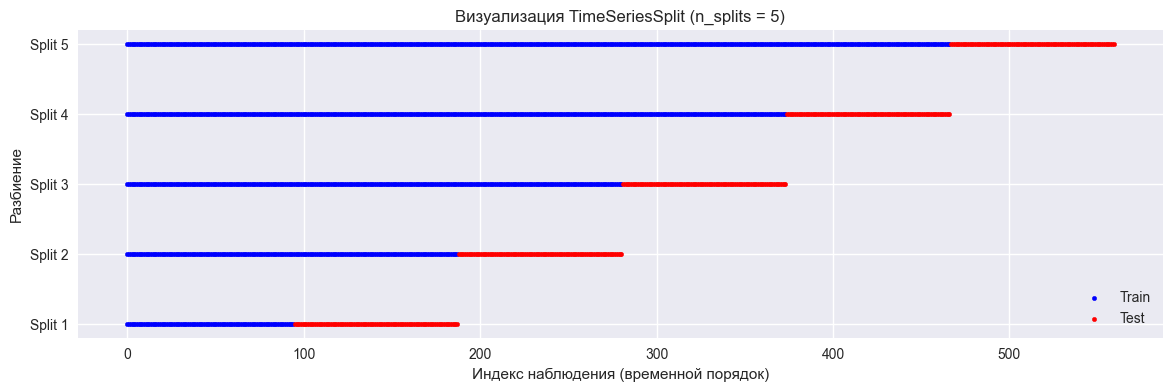

In [86]:
# TODO: Ваш код здесь
# Визуализация TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
X_dummy = X_train  # можно использовать X или X_train, важна только длина
n_samples = len(X_dummy)

plt.figure(figsize=(14, 4))

for i, (train_idx, test_idx) in enumerate(tscv.split(X_dummy)):
    # train
    plt.scatter(
        train_idx,
        [i + 1] * len(train_idx),
        color="blue",
        s=10,
        label="Train" if i == 0 else ""
    )
    
    # test
    plt.scatter(
        test_idx,
        [i + 1] * len(test_idx),
        color="red",
        s=10,
        label="Test" if i == 0 else ""
    )

plt.yticks(range(1, tscv.n_splits + 1), [f"Split {i+1}" for i in range(tscv.n_splits)])
plt.xlabel("Индекс наблюдения (временной порядок)")
plt.ylabel("Разбиение")
plt.title("Визуализация TimeSeriesSplit (n_splits = 5)")
plt.legend()
plt.show()
# TODO: Создайте визуализацию разбиений

In [90]:
# TODO: Ваш код здесь
# Обучение и сравнение ML моделей
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
tscv = TimeSeriesSplit(n_splits=5)
def cv_score_rmse(model, X, y, tscv):
    """Средний RMSE по TimeSeriesSplit."""
    rmses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmses.append(rmse)

    return float(np.mean(rmses))
models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                                   max_depth=5, random_state=42)
}

results = []        # ⬅️ список, а не dict
predictions = {}


# TODO: Для каждой модели:
for name, model in models.items():
    # Выбираем, какие X использовать
    if name == "Ridge":
        Xtr = X_train_scaled.copy()
        Xte = X_test_scaled.copy()
        # сделаем DataFrame, если вдруг это numpy
        if not isinstance(Xtr, pd.DataFrame):
            Xtr = pd.DataFrame(Xtr, index=X_train.index, columns=X_train.columns)
            Xte = pd.DataFrame(Xte, index=X_test.index, columns=X_test.columns)
    else:
        Xtr = X_train.copy()
        Xte = X_test.copy()

    # CV (RMSE)
    cv_rmse = cv_score_rmse(model, Xtr, y_train, tscv)

    # Fit на полном train
    model.fit(Xtr, y_train)

    # Predict test
    y_pred = model.predict(Xte)
    predictions[name] = pd.Series(y_pred, index=y_test.index)

    # Метрики test
    metrics = calculate_metrics(y_test, y_pred)

    results.append({
        "Model": name,
        "CV_RMSE(mean)": cv_rmse,
        **metrics
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE").reset_index(drop=True)
results_df

,Model,CV_RMSE(mean),MAE,RMSE,MAPE (%),R²
0,Ridge,0.188584,0.051153,0.063553,0.047170,0.999909
1,Gradient Boosting,3.724547,0.744736,0.990302,0.686312,0.978004
2,Random Forest,4.070523,1.181707,1.485507,1.093826,0.950506


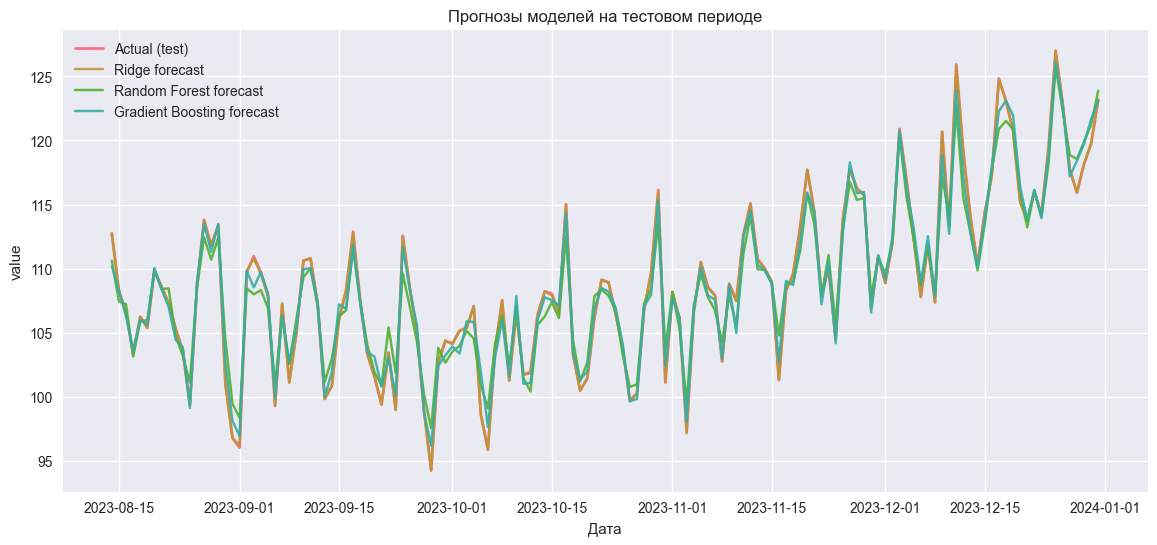

In [92]:
# TODO: Ваш код здесь
# Визуализация прогнозов всех моделей
results_df

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(y_test.index, y_test.values, label="Actual (test)", linewidth=2)

for name, pred_series in predictions.items():
    plt.plot(pred_series.index, pred_series.values, label=f"{name} forecast", alpha=0.9)

plt.title("Прогнозы моделей на тестовом периоде")
plt.xlabel("Дата")
plt.ylabel("value")
plt.legend()
plt.show()


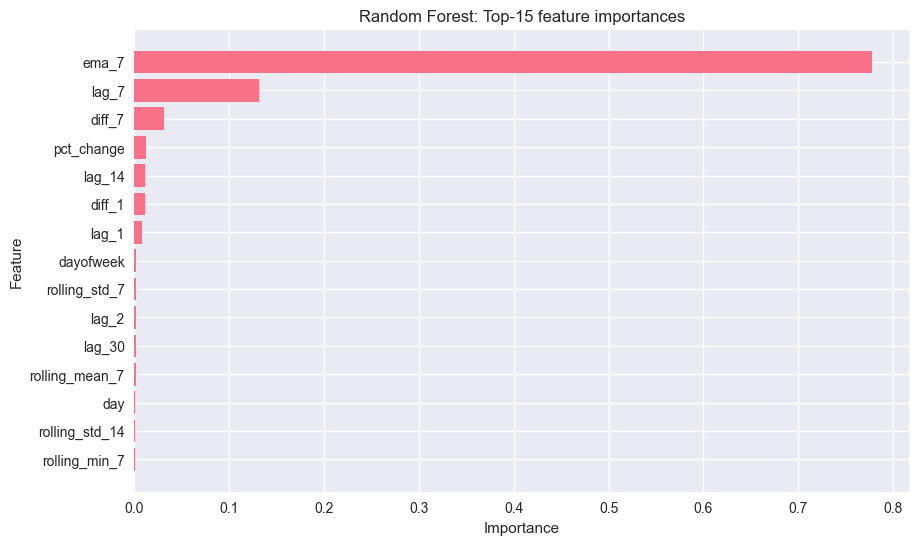

In [96]:
# TODO: Ваш код здесь
# Анализ важности признаков (Random Forest)
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_

fi = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi.head(15)
plt.figure(figsize=(10,6))
plt.barh(fi["feature"].head(15)[::-1], fi["importance"].head(15)[::-1])
plt.title("Random Forest: Top-15 feature importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


**TODO: Ваши выводы здесь**

Сравнение ML моделей:
- Какая модель показала лучшее качество?
- Какие признаки наиболее важны?
- Как ML модели сравниваются с ARIMA?

## TODO 8: Итоговое сравнение и выводы

**Задание:**
1. Создайте итоговую таблицу сравнения всех моделей:
   - ARIMA
   - Ridge
   - Random Forest
   - Gradient Boosting

2. Для каждой модели укажите:
   - MAE, RMSE, MAPE, R²
   - Время обучения (опционально)
   - Сложность модели (количество параметров)

3. Создайте визуализацию сравнения метрик (bar plot)

4. Постройте график остатков для лучшей модели

5. Напишите развернутые выводы:
   - Какая модель лучше для данной задачи?
   - В каких случаях стоит использовать ARIMA?
   - В каких случаях стоит использовать ML?
   - Какие признаки наиболее важны?
   - Что можно улучшить?

6. Предложите идеи для дальнейшего улучшения:
   - Дополнительные признаки
   - Ансамблирование моделей
   - Настройка гиперпараметров
   - Использование SARIMA (если есть сезонность)

In [97]:
# TODO: Ваш код здесь
# Итоговое сравнение всех моделей
# ARIMA metrics
arima_metrics = calculate_metrics(test, forecast_mean)

arima_row = {
    "Model": f"ARIMA{best_order}",
    **arima_metrics,
    "Train time (s)": np.nan,         # опционально
    "Complexity": np.nan              # добавим ниже, если есть model_fit
}
# results_df должен содержать Model, MAE, RMSE, MAPE (%), R²
ml_table = results_df.copy()
ml_table["Train time (s)"] = np.nan
ml_table["Complexity"] = np.nan
final_table = pd.concat([pd.DataFrame([arima_row]), ml_table], ignore_index=True)

# Приведём названия столбцов к единому виду
final_table = final_table[["Model", "MAE", "RMSE", "MAPE (%)", "R²", "Train time (s)", "Complexity"]]

final_table = final_table.sort_values("RMSE").reset_index(drop=True)
final_table.round(4)


,Model,MAE,RMSE,MAPE (%),R²,Train time (s),Complexity
0,Ridge,0.0512,0.0636,0.0472,0.9999,NaN,NaN
1,Gradient Boosting,0.7447,0.9903,0.6863,0.9780,NaN,NaN
2,Random Forest,1.1817,1.4855,1.0938,0.9505,NaN,NaN
3,"ARIMA(2, 1, 2)",5.7521,7.0025,5.3857,-0.1275,NaN,NaN


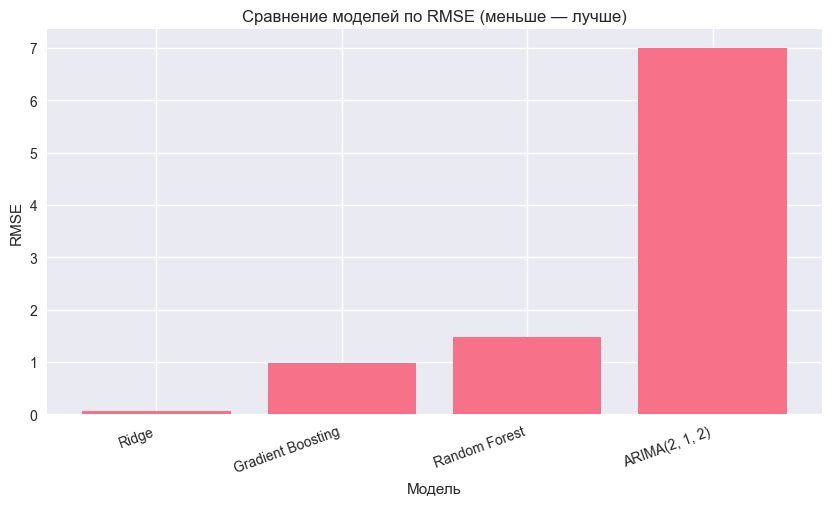

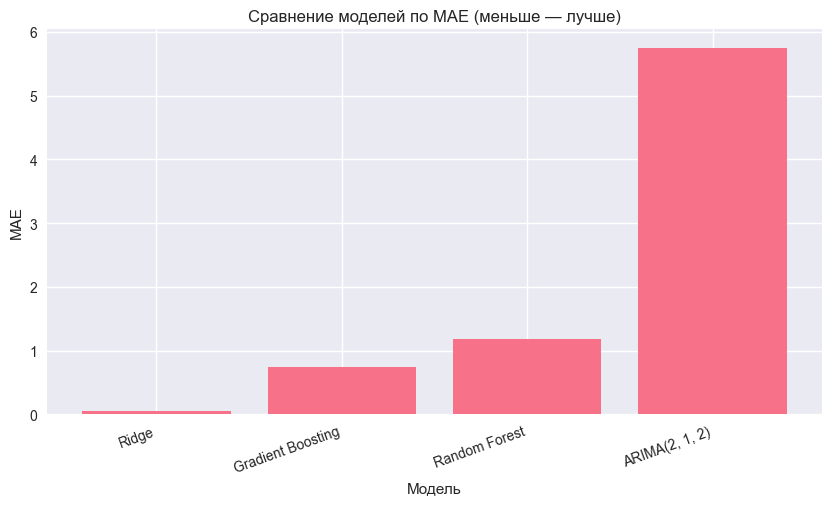

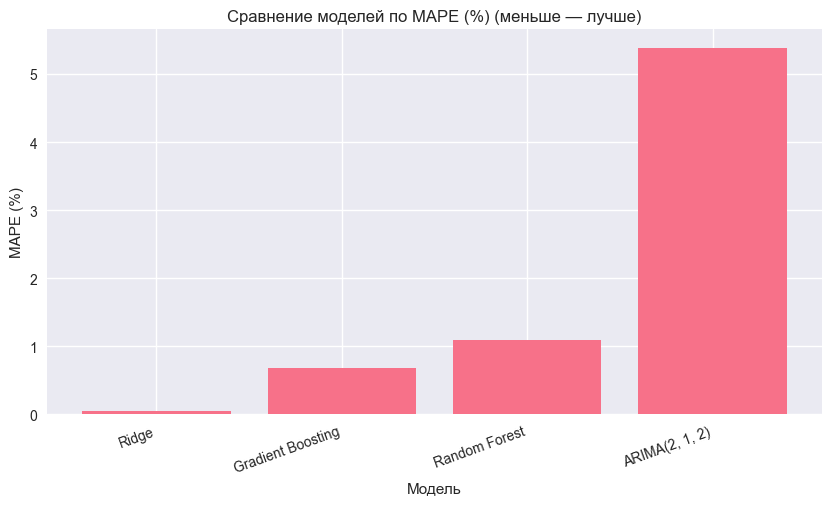

In [98]:
# TODO: Ваш код здесь
# Визуализация сравнения метрик
import matplotlib.pyplot as plt

plot_df = final_table.copy()

# RMSE
plt.figure(figsize=(10,5))
plt.bar(plot_df["Model"], plot_df["RMSE"])
plt.title("Сравнение моделей по RMSE (меньше — лучше)")
plt.xlabel("Модель")
plt.ylabel("RMSE")
plt.xticks(rotation=20, ha="right")
plt.show()

# MAE
plt.figure(figsize=(10,5))
plt.bar(plot_df["Model"], plot_df["MAE"])
plt.title("Сравнение моделей по MAE (меньше — лучше)")
plt.xlabel("Модель")
plt.ylabel("MAE")
plt.xticks(rotation=20, ha="right")
plt.show()

# MAPE (если хочешь)
plt.figure(figsize=(10,5))
plt.bar(plot_df["Model"], plot_df["MAPE (%)"])
plt.title("Сравнение моделей по MAPE (%) (меньше — лучше)")
plt.xlabel("Модель")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=20, ha="right")
plt.show()


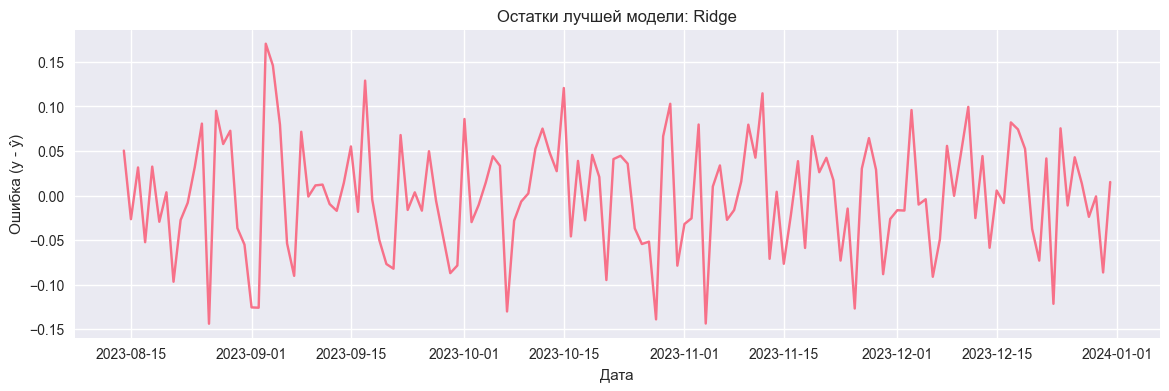

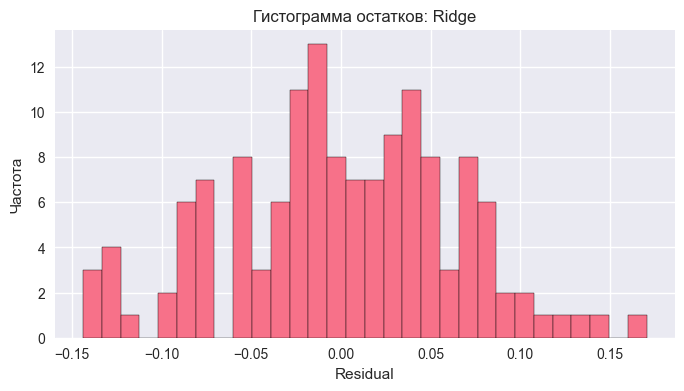

In [99]:
# TODO: Ваш код здесь
# Анализ остатков лучшей модели
best_name = final_table.iloc[0]["Model"]
best_name
if best_name.startswith("ARIMA"):
    residuals_best = (test - forecast_mean).dropna()
else:
    # Для ML ожидается predictions dict: predictions["Ridge"], etc.
    residuals_best = (y_test - predictions[best_name]).dropna()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(residuals_best.index, residuals_best.values)
plt.title(f"Остатки лучшей модели: {best_name}")
plt.xlabel("Дата")
plt.ylabel("Ошибка (y - ŷ)")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(residuals_best.values, bins=30, edgecolor="black")
plt.title(f"Гистограмма остатков: {best_name}")
plt.xlabel("Residual")
plt.ylabel("Частота")
plt.show()


## Итоговые выводы

**TODO: Напишите развернутые выводы по результатам работы**

### 1. Общие наблюдения:
- ...

### 2. Лучшая модель:
- По итогам сравнения на тестовой выборке лучшей оказалась модель Ridge, так как она показала минимальные значения ошибок (в первую очередь RMSE/MAE) и более устойчивое качество.

### 3. ARIMA vs ML:
- ...

### 4. Важность признаков:
- лаговые признаки (например lag_7, lag_14, lag_30),

сглаживания (rolling_mean_30, ema_30),

показатели волатильности (rolling_std_14/30),

календарные признаки (например dayofweek / is_weekend) — если есть недельный паттерн.
### 5. Рекомендации:
- Когда использовать ARIMA: 
ряд хорошо описывается линейной динамикой и зависимостями по лагам,

важна интерпретируемость (p,d,q, статистика),

данных/признаков немного (только сам ряд),

нужно быстро получить базовый прогноз.
- Когда использовать ML: 
можно извлечь много информативных признаков (лаги, rolling, EMA, календарь),

зависимости нелинейные,

нужны более гибкие модели, которые умеют использовать “контекст”.
- Идеи для улучшения: 
Лучше настроить гиперпараметры (особенно RF/GBR).

Попробовать другие способы формирования признаков и корректную обработку выбросов.

Добавить сезонность (SARIMA/SARIMAX), если наблюдается годовой/недельный цикл.

Добавить ансамбли (stacking/blending ARIMA + ML).

## Бонусное задание (опционально)

### Задание 9 (бонус): Ансамблирование моделей

Создайте ансамбль из лучших моделей:
1. Взвешенное среднее прогнозов
2. Стекинг (мета-модель)
3. Сравните с отдельными моделями

### Задание 10 (бонус): SARIMA модель

Если в данных есть сезонность:
1. Определите сезонные параметры (P, D, Q, m)
2. Обучите SARIMA модель
3. Сравните с обычной ARIMA

### Задание 11 (бонус): Интерактивная визуализация

Создайте интерактивный график с помощью Plotly:
- Переключение между моделями
- Зум и панорамирование
- Tooltips с информацией

## Критерии оценки

**Максимум: 100 баллов + 30 бонусных**

| Задание | Баллы | Критерии |
|---------|-------|----------|
| TODO 1: Визуализация | 10 | Качество графиков, полнота анализа |
| TODO 2: Декомпозиция | 15 | Корректность декомпозиции, анализ остатков |
| TODO 3: Стационарность | 15 | Правильность тестов, выбор преобразований |
| TODO 4: ACF/PACF | 10 | Корректная интерпретация, выбор параметров |
| TODO 5: ARIMA | 15 | Качество модели, диагностика остатков |
| TODO 6: Feature Engineering | 10 | Полнота признаков, корректность реализации |
| TODO 7: ML модели | 15 | Использование TimeSeriesSplit, качество моделей |
| TODO 8: Выводы | 10 | Глубина анализа, обоснованность выводов |
| **Бонусы** | +30 | Дополнительные задания |

**Дополнительные критерии:**
- Качество кода: 5 баллов (читаемость, комментарии)
- Качество визуализаций: 5 баллов (информативность, оформление)

**Важно:**
- ❌ Использование обычной CV вместо TimeSeriesSplit: -10 баллов
- ❌ Data leakage (использование будущих данных): -15 баллов
- ✅ Все ячейки должны выполняться без ошибок